# Продолжение финального проекта

План:

1. Сбор признаков в единый датасет.
    - Датасет по электродам,
    - Датасет по результатам измерения температуры,
    - Датасет по сыпучим материалам,
    - Датасет по проволочным материалам,
    - Датасет по продувке сплава газом.
2. Подбор моделей.
3. Stacking and Blending.
4. Тестирование моделей.
5. Заключение.
    

## 1. Сбор признаков в единый датасет.

## Датасет по электродам.

Загрузим данные, рассчитаем время между нагревами, отношение Активной мощности к Реактивной и Полную мощность через треугольник мощностей.

In [1]:
import pandas as pd
import numpy as np

arcs_df = pd.read_csv('data_arc.csv', 
                     parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
arcs_df['Время нагрева']       = arcs_df['Конец нагрева дугой'] - arcs_df['Начало нагрева дугой']
arcs_df['Время нагрева (сек)'] = arcs_df['Время нагрева'].dt.total_seconds()
arcs_df.drop('Время нагрева', axis=1, inplace=True)
arcs_df['Отношение мощностей'] = arcs_df['Активная мощность'] / arcs_df['Реактивная мощность']
arcs_df['Полная мощность']     = np.sqrt(arcs_df['Активная мощность']**2 + arcs_df['Реактивная мощность']**2)
arcs_df.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева (сек),Отношение мощностей,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.420582,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.548395,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.492292,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.561504,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1.671717,0.807239


Обработаем аномалии.

In [2]:
arcs_df[arcs_df['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева (сек),Отношение мощностей,Полная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109.0,-0.000693,715.505096


In [3]:
arcs_df.loc[9780, 'Реактивная мощность'] = arcs_df.pivot_table(index='key',\
                                                values='Реактивная мощность', aggfunc='median').iloc[2116].values[0]

In [4]:
arcs_df[arcs_df['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева (сек),Отношение мощностей,Полная мощность


Создадим признаки через агрегацию по номеру партии:

- Суммарное время нагрева в секундах,
- Количество нагревов в партии,
- Среднее время нагрева каждой партии в секундах,
- Средняя Активная мощность на партию,
- Средняя Реактивная мощность на партию,
- Среднее отношение Активной мощности к Реактивной на партию.
- Средняя Полная мощность на партию.

In [5]:
summary_time = arcs_df.pivot_table(index='key', values='Время нагрева (сек)', aggfunc='sum')
num_of_iter = arcs_df.pivot_table(index='key', values='Время нагрева (сек)', aggfunc='count')
mean_heat_time = arcs_df.pivot_table(index='key', values='Время нагрева (сек)')
mean_A_power = arcs_df.pivot_table(index='key', values='Активная мощность')
mean_P_power = arcs_df.pivot_table(index='key', values='Реактивная мощность')
mean_ratio = arcs_df.pivot_table(index='key', values='Отношение мощностей')
mean_S_power = arcs_df.pivot_table(index='key', values='Полная мощность')

arcs_aggregated = pd.concat([summary_time,num_of_iter, mean_A_power,\
                             mean_P_power,mean_heat_time,mean_ratio,mean_S_power], axis=1)
arcs_aggregated.columns = ['Суммарное время нагрева (сек)', 'Количество нагревов',\
                     'Средняя Активная мощность', 'Средняя Реактивная мощность',\
                           'Среднее Время Нагрева (сек)', 'Среднее отношение мощностей', 'Средняя полная мощность']
arcs_aggregated.head()

,Суммарное время нагрева (сек),Количество нагревов,Средняя Активная мощность,Средняя Реактивная мощность,Среднее Время Нагрева (сек),Среднее отношение мощностей,Средняя полная мощность
key,,,,,,,
1,1098.0,5,0.975629,0.636648,219.60,1.538898,1.165279
2,811.0,4,0.763150,0.499528,202.75,1.551834,0.912304
3,655.0,5,0.505176,0.319815,131.00,1.583120,0.597907
4,741.0,4,0.802313,0.515074,185.25,1.563487,0.953741
5,869.0,4,0.836793,0.563161,217.25,1.480428,1.008939


## Датасет по результатам измерения температуры.

Загрузим данные, извлечем время и значение первого и последнего значения температуры.

In [6]:
df_temp = pd.read_csv('data_temp.csv', parse_dates=['Время замера'])
first_and_last = df_temp.pivot_table(index='key', values=['Время замера', 'Температура'], aggfunc=['first', 'last'])
first_and_last.columns = ['first_measure', 'first_temp', 'last_measure', 'last_temp']
first_and_last['time'] = first_and_last['last_measure'] - first_and_last['first_measure']
first_and_last['total_measure_time_sec'] = first_and_last['time'].dt.total_seconds()
first_and_last.drop(['first_measure', 'last_measure', 'time'], axis=1, inplace=True)
first_and_last.columns = ['Первая температура', 'Последняя температура', 'Время между замерами (сек)']
first_and_last.head()

,Первая температура,Последняя температура,Время между замерами (сек)
key,,,
1,1571.0,1613.0,861.0
2,1581.0,1602.0,1305.0
3,1596.0,1599.0,1300.0
4,1601.0,1625.0,388.0
5,1576.0,1602.0,762.0


Чтобы найти партии, в которых не известна последняя температура, мы сначала находим те, в которых первое и последнее значение равны, а потом вычленяем из них те, в которых присутствуют пропуски. Было замечено, что если есть пропуски в партии, в которой первая и последняя температура равны, то пропуск захватывает и последнее значение.

Список already_deleted хранит в себе партии, которые удалятся в результате слияния, поэтому их надо убрать из списка, чтобы не вылетела ошибка.

In [8]:
indicies = first_and_last[first_and_last['Первая температура'] == first_and_last['Последняя температура']].index
f_l_equal = df_temp[df_temp['key'].isin(indicies)]
keys_without_last = f_l_equal[f_l_equal['Температура'].isnull()]['key'].unique().tolist()

already_deleted = [2582, 2738, 2795, 2841, 3026, 3059, 3112]
for val in already_deleted:
    keys_without_last.remove(val)

Последняя температура будет целевым признаком.

Объединим датасеты с признаками из датасета по электродам с признаками из датасета по замерам температуры.

In [9]:
first_merge  = pd.merge(first_and_last,arcs_aggregated, right_index=True, left_index=True)
first_merge.head()

,Первая температура,Последняя температура,Время между замерами (сек),Суммарное время нагрева (сек),Количество нагревов,Средняя Активная мощность,Средняя Реактивная мощность,Среднее Время Нагрева (сек),Среднее отношение мощностей,Средняя полная мощность
key,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,0.975629,0.636648,219.60,1.538898,1.165279
2,1581.0,1602.0,1305.0,811.0,4,0.763150,0.499528,202.75,1.551834,0.912304
3,1596.0,1599.0,1300.0,655.0,5,0.505176,0.319815,131.00,1.583120,0.597907
4,1601.0,1625.0,388.0,741.0,4,0.802313,0.515074,185.25,1.563487,0.953741
5,1576.0,1602.0,762.0,869.0,4,0.836793,0.563161,217.25,1.480428,1.008939


Проверим на аномалии: нас не интересуют патрии, в которых всего 1 нагрев. Посмотрим сколько таких.

In [10]:
print('Количество партий с 1 нагревом: {}.'.format(first_merge[first_merge['Количество нагревов'] == 1].shape[0]))

Количество партий с 1 нагревом: 39.


Избавимся от них.

In [11]:
first_merge = first_merge[first_merge['Количество нагревов'] != 1]

Скидываем партии без последней температуры.

In [12]:
first_merge.drop(keys_without_last, inplace=True)

## Датасет по сыпучим материалам.

Загрузим данные и обработаем пропуски нулями, характеризующие отсутствие добавление материала.

In [13]:
bulk_volume_df = pd.read_csv('data_bulk.csv', index_col = 0)
bulk_volume_df.fillna(0, inplace=True)
bulk_volume_df.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Проведем объединение.

In [14]:
second_merge = pd.merge(first_merge,bulk_volume_df, right_index=True, left_index=True)
second_merge.head()

,Первая температура,Последняя температура,Время между замерами (сек),Суммарное время нагрева (сек),Количество нагревов,Средняя Активная мощность,Средняя Реактивная мощность,Среднее Время Нагрева (сек),Среднее отношение мощностей,Средняя полная мощность,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,0.975629,0.636648,219.60,1.538898,1.165279,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,1581.0,1602.0,1305.0,811.0,4,0.763150,0.499528,202.75,1.551834,0.912304,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1596.0,1599.0,1300.0,655.0,5,0.505176,0.319815,131.00,1.583120,0.597907,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,1601.0,1625.0,388.0,741.0,4,0.802313,0.515074,185.25,1.563487,0.953741,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,1576.0,1602.0,762.0,869.0,4,0.836793,0.563161,217.25,1.480428,1.008939,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Датасет по проволочным материалам.

Здесь логика такая же как и в случае с сыпучими материалами.

In [15]:
wire_volume_df = pd.read_csv('data_wire.csv', index_col=0)
wire_volume_df.fillna(0, inplace=True)
wire_volume_df.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объединяем.

In [16]:
third_merge = pd.merge(second_merge,wire_volume_df, right_index=True, left_index=True)
third_merge.head()

,Первая температура,Последняя температура,Время между замерами (сек),Суммарное время нагрева (сек),Количество нагревов,Средняя Активная мощность,Средняя Реактивная мощность,Среднее Время Нагрева (сек),Среднее отношение мощностей,Средняя полная мощность,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,0.975629,0.636648,219.60,1.538898,1.165279,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,1305.0,811.0,4,0.763150,0.499528,202.75,1.551834,0.912304,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,1300.0,655.0,5,0.505176,0.319815,131.00,1.583120,0.597907,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,388.0,741.0,4,0.802313,0.515074,185.25,1.563487,0.953741,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,762.0,869.0,4,0.836793,0.563161,217.25,1.480428,1.008939,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Датасет по продувке сплава газом.

Загружаем данные.

In [17]:
gas_df = pd.read_csv('data_gas.csv', index_col=0)
gas_df.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Объединяем.

In [18]:
result = pd.merge(third_merge,gas_df, right_index=True, left_index=True)
result.head()

,Первая температура,Последняя температура,Время между замерами (сек),Суммарное время нагрева (сек),Количество нагревов,Средняя Активная мощность,Средняя Реактивная мощность,Среднее Время Нагрева (сек),Среднее отношение мощностей,Средняя полная мощность,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,0.975629,0.636648,219.60,1.538898,1.165279,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,1305.0,811.0,4,0.763150,0.499528,202.75,1.551834,0.912304,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,1300.0,655.0,5,0.505176,0.319815,131.00,1.583120,0.597907,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,388.0,741.0,4,0.802313,0.515074,185.25,1.563487,0.953741,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,762.0,869.0,4,0.836793,0.563161,217.25,1.480428,1.008939,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [19]:
print('Количество оставшихся партий: {}.'.format(result.shape[0]))

Количество оставшихся партий: 2304.


Взглянем на корреляцию признаков.

(35.5, -0.5)

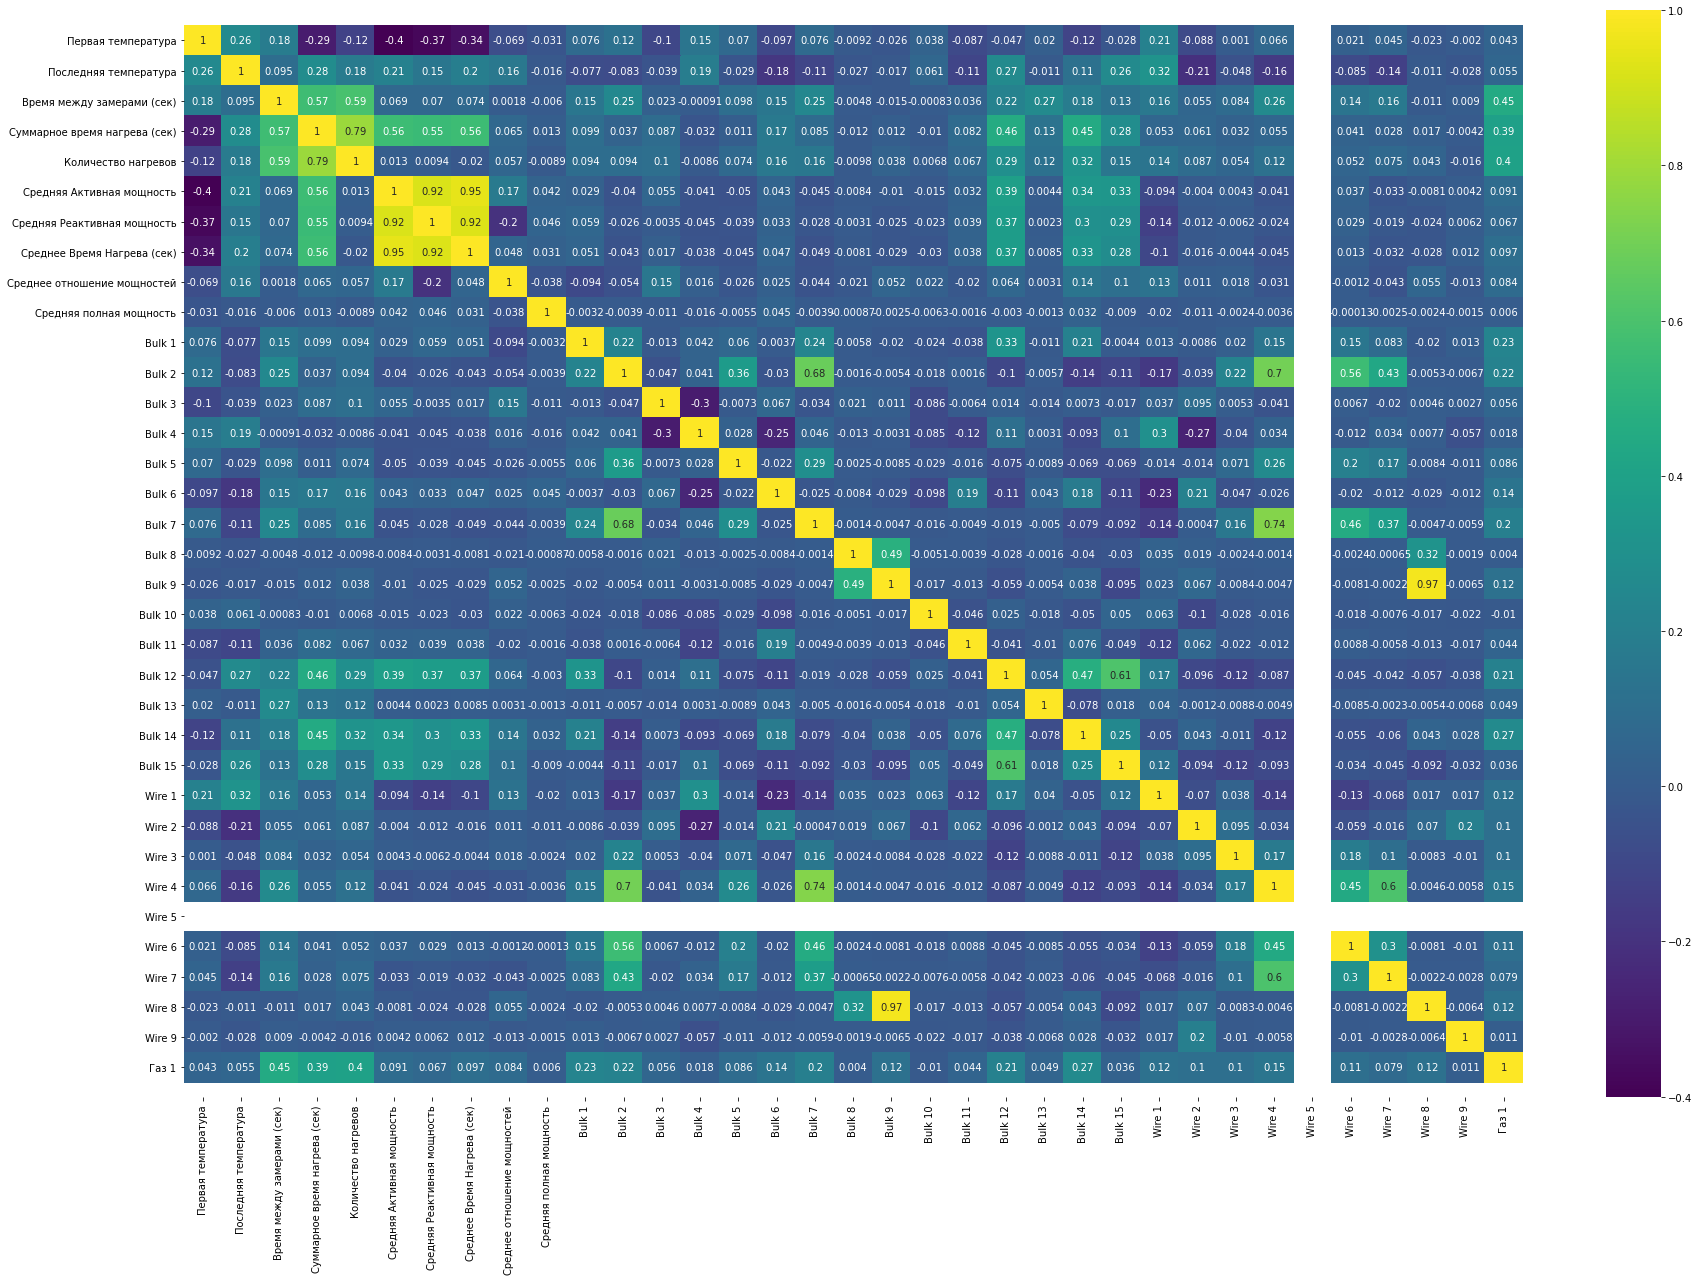

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,20))
ax = sns.heatmap(result.corr(), annot=True, cmap="viridis") 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Выделим пары признаков с корреляцией 0.75 и выше:

- Bulk 9 - Wire 8,
- Средняя Активная мощность - Средняя Реактивная мощность,
- Средняя Активная мощность - Среднее Время нагрева (сек),
- Суммарное время нагрева - Количество нагревов,
- Bulk 7 - Bulk 2.

Удалим ненужное, чтобы решить проблему мультиколлинеарности.

In [21]:
result.drop(['Wire 8', 'Средняя Реактивная мощность',\
             'Среднее Время Нагрева (сек)', 'Количество нагревов', 'Bulk 2'], inplace=True, axis=1)

## 2. Подбор моделей.

Выделим обычные признаки от целевого, разобьем датасет на обучающую и тестовую выборки и нормализуем их.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = result.drop('Последняя температура',axis=1)
target   = result['Последняя температура']

scaler = StandardScaler()

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

features_train = scaler.fit_transform(features_train)
features_test  = scaler.transform(features_test)

print('Количество партий в обучающей выборке: {}'.format(features_train.shape[0]))
print('Количество партий в тестовой выборке: {}'.format(features_test.shape[0]))

Количество партий в обучающей выборке: 1843
Количество партий в тестовой выборке: 461


Подберем случайный лес.

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

param_grid = {
    'n_estimators': np.arange(40,220,20),
    'max_depth': np.arange(4,20,4),
    'min_samples_split': np.arange(5,20,3)
}

model      = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=5, 
            n_jobs=-1,
            n_iter=30,
            scoring='neg_mean_absolute_error',
            verbose=2
        )

rnd_search.fit(features_train, target_train)
print(rnd_search.best_score_)
rnd_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


-5.999678353976487


RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=160,
                      random_state=42)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=160,
                      random_state=42)
cross_val = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error')
(-1)*cross_val.mean()

5.999678353976487

Теперь посмотрим на работу метода опорных элементов.

In [25]:
from sklearn.svm import SVR

param_grid = {
    'kernel': ['rbf'],
    'C': np.arange(5, 110, 15)
}

model      = SVR()
rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=30. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


5.794578472903631


SVR(C=20)

Лучше, выжмем максимум из этой модели.

In [26]:
param_grid = {
    'kernel': ['rbf'],
    'C': np.arange(5, 25, 1)
}

model      = SVR()
rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


5.767412144667175


SVR(C=13)

In [27]:
model = SVR(kernel='rbf', C=13)
cross_val = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error')
(-1)*cross_val.mean()

5.767412144667175

Попробуем LightGBM.

In [28]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
param_grid = {
    'n_estimators': np.arange(40,220,20),
    'max_depth': np.arange(4,20,4),
    'num_leaves': np.arange(10,100,10)
}

rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

5.806191500757102


LGBMRegressor(max_depth=8, n_estimators=60, num_leaves=40)

In [29]:
model = lgb.LGBMRegressor()
param_grid = {
    'n_estimators': np.arange(50,70,2),
    'max_depth': [7,8,9],
    'num_leaves': np.arange(35,45,1)
}

rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

5.8059600732650125


LGBMRegressor(max_depth=7, n_estimators=58, num_leaves=40)

In [30]:
model = lgb.LGBMRegressor(max_depth=7, n_estimators=58, num_leaves=40)
cross_val = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error')
(-1)*cross_val.mean()

5.8059600732650125

Еще чуть-чуть улучшили результат.

Посмотрим на работу Линейных моделей.

In [31]:
from sklearn.linear_model import Lasso

param_grid = {
    'alpha': np.arange(0.,2,0.01)
}
model      = Lasso(random_state=42)

rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=30, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

6.265811426920542


Lasso(alpha=0.15, random_state=42)

In [32]:
model = Lasso(random_state=42, alpha=0.15)
cross_val = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error')
(-1)*cross_val.mean()

6.265811426920542

 Попробуем теперь CatBoost.

In [34]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
param_grid = {
    'depth': np.arange(6,18,4),
    'learning_rate': [0.2],
    'iterations': [50, 75, 100]
}

rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)
rnd_search.fit(features_train, target_train)
print(-rnd_search.best_score_)
rnd_search.best_estimator_

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 10.5731581	total: 6.36ms	remaining: 311ms
1:	learn: 10.1218114	total: 12.6ms	remaining: 302ms
2:	learn: 9.6389986	total: 17.6ms	remaining: 276ms
3:	learn: 9.3505036	total: 22.8ms	remaining: 262ms
4:	learn: 9.0469613	total: 27.2ms	remaining: 244ms
5:	learn: 8.8255444	total: 33.4ms	remaining: 245ms
6:	learn: 8.6447191	total: 41.6ms	remaining: 255ms
7:	learn: 8.4942163	total: 46.2ms	remaining: 242ms
8:	learn: 8.3213420	total: 50.5ms	remaining: 230ms
9:	learn: 8.1837878	total: 54.9ms	remaining: 220ms
10:	learn: 8.0278523	total: 60.5ms	remaining: 215ms
11:	learn: 7.9085562	total: 64.8ms	remaining: 205ms
12:	learn: 7.7884152	total: 70.1ms	remaining: 199ms
13:	learn: 7.7260644	total: 74.1ms	remaining: 191ms
14:	learn: 7.6502779	total: 78.3ms	remaining: 183ms
15:	learn: 7.5525076	total: 82.9ms	remaining: 176ms
16:	learn: 7.4464937	total: 87.2ms	remaining: 169ms
17:	learn: 7.3814357	total: 91.3ms	remaining: 162ms
18:	learn: 7.3249595	total: 95.3ms	remaining: 155ms
19:	learn: 7.1931822

17:	learn: 7.4996365	total: 74.8ms	remaining: 133ms
18:	learn: 7.4124071	total: 79.7ms	remaining: 130ms
19:	learn: 7.3434178	total: 84.7ms	remaining: 127ms
20:	learn: 7.3077028	total: 89.7ms	remaining: 124ms
21:	learn: 7.2381350	total: 95.6ms	remaining: 122ms
22:	learn: 7.1783339	total: 102ms	remaining: 120ms
23:	learn: 7.0736980	total: 107ms	remaining: 116ms
24:	learn: 7.0077946	total: 112ms	remaining: 112ms
25:	learn: 6.9367843	total: 117ms	remaining: 108ms
26:	learn: 6.8890645	total: 123ms	remaining: 105ms
27:	learn: 6.8435717	total: 128ms	remaining: 101ms
28:	learn: 6.7777308	total: 133ms	remaining: 96.4ms
29:	learn: 6.7400400	total: 138ms	remaining: 92.1ms
30:	learn: 6.6964503	total: 143ms	remaining: 87.7ms
31:	learn: 6.6721234	total: 148ms	remaining: 83.4ms
32:	learn: 6.6225339	total: 153ms	remaining: 79ms
33:	learn: 6.5714807	total: 158ms	remaining: 74.5ms
34:	learn: 6.5039854	total: 163ms	remaining: 70ms
35:	learn: 6.4766220	total: 169ms	remaining: 65.6ms
36:	learn: 6.4016620	t

5:	learn: 9.1152578	total: 26.1ms	remaining: 300ms
6:	learn: 8.9278869	total: 31.9ms	remaining: 310ms
7:	learn: 8.8135780	total: 37.3ms	remaining: 312ms
8:	learn: 8.6687680	total: 42.4ms	remaining: 311ms
9:	learn: 8.4999553	total: 47.8ms	remaining: 311ms
10:	learn: 8.3330203	total: 52.4ms	remaining: 305ms
11:	learn: 8.1848110	total: 56.6ms	remaining: 297ms
12:	learn: 8.0408178	total: 61.3ms	remaining: 292ms
13:	learn: 7.9327792	total: 65.4ms	remaining: 285ms
14:	learn: 7.8528320	total: 69.4ms	remaining: 278ms
15:	learn: 7.7341315	total: 73.5ms	remaining: 271ms
16:	learn: 7.6649142	total: 77.7ms	remaining: 265ms
17:	learn: 7.5974903	total: 81.6ms	remaining: 259ms
18:	learn: 7.5470064	total: 85.6ms	remaining: 252ms
19:	learn: 7.5073176	total: 89.6ms	remaining: 247ms
20:	learn: 7.4639459	total: 93.6ms	remaining: 241ms
21:	learn: 7.4137085	total: 97.7ms	remaining: 235ms
22:	learn: 7.3472379	total: 102ms	remaining: 230ms
23:	learn: 7.2926983	total: 106ms	remaining: 225ms
24:	learn: 7.254509

46:	learn: 5.9712158	total: 195ms	remaining: 116ms
47:	learn: 5.9581858	total: 200ms	remaining: 113ms
48:	learn: 5.9256037	total: 205ms	remaining: 109ms
49:	learn: 5.8567798	total: 210ms	remaining: 105ms
50:	learn: 5.7913350	total: 215ms	remaining: 101ms
51:	learn: 5.7679552	total: 220ms	remaining: 97.5ms
52:	learn: 5.7120233	total: 225ms	remaining: 93.2ms
53:	learn: 5.6664945	total: 229ms	remaining: 89.2ms
54:	learn: 5.6169111	total: 234ms	remaining: 84.9ms
55:	learn: 5.5782612	total: 238ms	remaining: 80.7ms
56:	learn: 5.5352023	total: 242ms	remaining: 76.4ms
57:	learn: 5.4857543	total: 246ms	remaining: 72.2ms
58:	learn: 5.4591498	total: 250ms	remaining: 67.9ms
59:	learn: 5.4324928	total: 254ms	remaining: 63.6ms
60:	learn: 5.4030283	total: 259ms	remaining: 59.4ms
61:	learn: 5.3747439	total: 263ms	remaining: 55.1ms
62:	learn: 5.3400039	total: 267ms	remaining: 50.8ms
63:	learn: 5.3020790	total: 271ms	remaining: 46.5ms
64:	learn: 5.2499899	total: 275ms	remaining: 42.3ms
65:	learn: 5.2111

84:	learn: 4.8725446	total: 358ms	remaining: 63.2ms
85:	learn: 4.8326756	total: 363ms	remaining: 59.1ms
86:	learn: 4.8296614	total: 368ms	remaining: 55ms
87:	learn: 4.7974038	total: 373ms	remaining: 50.9ms
88:	learn: 4.7949409	total: 378ms	remaining: 46.7ms
89:	learn: 4.7533036	total: 384ms	remaining: 42.6ms
90:	learn: 4.7493199	total: 388ms	remaining: 38.4ms
91:	learn: 4.7170036	total: 392ms	remaining: 34.1ms
92:	learn: 4.7105085	total: 396ms	remaining: 29.8ms
93:	learn: 4.6862716	total: 400ms	remaining: 25.6ms
94:	learn: 4.6482159	total: 405ms	remaining: 21.3ms
95:	learn: 4.6258139	total: 409ms	remaining: 17.1ms
96:	learn: 4.5941253	total: 413ms	remaining: 12.8ms
97:	learn: 4.5736566	total: 418ms	remaining: 8.53ms
98:	learn: 4.5466604	total: 422ms	remaining: 4.26ms
99:	learn: 4.5352911	total: 426ms	remaining: 0us
0:	learn: 10.8538259	total: 6.28ms	remaining: 622ms
1:	learn: 10.3530198	total: 12.4ms	remaining: 607ms
2:	learn: 9.9643448	total: 17.8ms	remaining: 576ms
3:	learn: 9.641087

52:	learn: 5.9061403	total: 237ms	remaining: 210ms
53:	learn: 5.8609339	total: 242ms	remaining: 206ms
54:	learn: 5.8483411	total: 248ms	remaining: 203ms
55:	learn: 5.8090450	total: 253ms	remaining: 199ms
56:	learn: 5.7783241	total: 258ms	remaining: 194ms
57:	learn: 5.7277469	total: 262ms	remaining: 190ms
58:	learn: 5.6785111	total: 268ms	remaining: 186ms
59:	learn: 5.6383184	total: 272ms	remaining: 181ms
60:	learn: 5.5930554	total: 276ms	remaining: 177ms
61:	learn: 5.5477902	total: 281ms	remaining: 172ms
62:	learn: 5.5399469	total: 285ms	remaining: 167ms
63:	learn: 5.5110475	total: 289ms	remaining: 163ms
64:	learn: 5.5069150	total: 294ms	remaining: 158ms
65:	learn: 5.4569028	total: 298ms	remaining: 154ms
66:	learn: 5.4300433	total: 303ms	remaining: 149ms
67:	learn: 5.3937447	total: 307ms	remaining: 144ms
68:	learn: 5.3435962	total: 311ms	remaining: 140ms
69:	learn: 5.3165826	total: 316ms	remaining: 135ms
70:	learn: 5.3134657	total: 320ms	remaining: 131ms
71:	learn: 5.2865003	total: 324

38:	learn: 6.4025586	total: 188ms	remaining: 294ms
39:	learn: 6.3774724	total: 193ms	remaining: 290ms
40:	learn: 6.3250511	total: 199ms	remaining: 286ms
41:	learn: 6.2754103	total: 204ms	remaining: 282ms
42:	learn: 6.2501695	total: 209ms	remaining: 278ms
43:	learn: 6.2220987	total: 215ms	remaining: 273ms
44:	learn: 6.2041307	total: 219ms	remaining: 268ms
45:	learn: 6.1590746	total: 224ms	remaining: 263ms
46:	learn: 6.1080885	total: 228ms	remaining: 257ms
47:	learn: 6.0815945	total: 233ms	remaining: 252ms
48:	learn: 6.0299419	total: 237ms	remaining: 247ms
49:	learn: 6.0012934	total: 242ms	remaining: 242ms
50:	learn: 5.9630782	total: 246ms	remaining: 237ms
51:	learn: 5.9503412	total: 251ms	remaining: 232ms
52:	learn: 5.9111344	total: 256ms	remaining: 227ms
53:	learn: 5.8380904	total: 260ms	remaining: 222ms
54:	learn: 5.8138375	total: 265ms	remaining: 216ms
55:	learn: 5.7672032	total: 269ms	remaining: 211ms
56:	learn: 5.7468707	total: 273ms	remaining: 206ms
57:	learn: 5.6958123	total: 278

0:	learn: 10.4446527	total: 70.9ms	remaining: 3.47s
1:	learn: 9.8856223	total: 159ms	remaining: 3.82s
2:	learn: 9.4131346	total: 248ms	remaining: 3.89s
3:	learn: 8.9736073	total: 342ms	remaining: 3.94s
4:	learn: 8.5923457	total: 436ms	remaining: 3.93s
5:	learn: 8.2609876	total: 529ms	remaining: 3.88s
6:	learn: 7.9995458	total: 616ms	remaining: 3.79s
7:	learn: 7.7152692	total: 707ms	remaining: 3.71s
8:	learn: 7.5331813	total: 781ms	remaining: 3.56s
9:	learn: 7.3268725	total: 855ms	remaining: 3.42s
10:	learn: 7.1293812	total: 945ms	remaining: 3.35s
11:	learn: 6.9288405	total: 1.03s	remaining: 3.25s
12:	learn: 6.8065398	total: 1.1s	remaining: 3.13s
13:	learn: 6.6683367	total: 1.17s	remaining: 3.01s
14:	learn: 6.5161116	total: 1.24s	remaining: 2.9s
15:	learn: 6.4056009	total: 1.31s	remaining: 2.79s
16:	learn: 6.3152335	total: 1.38s	remaining: 2.69s
17:	learn: 6.2408956	total: 1.46s	remaining: 2.6s
18:	learn: 6.1453026	total: 1.54s	remaining: 2.51s
19:	learn: 6.0160543	total: 1.62s	remainin

12:	learn: 6.7737606	total: 1.03s	remaining: 4.93s
13:	learn: 6.6448141	total: 1.1s	remaining: 4.81s
14:	learn: 6.4967971	total: 1.17s	remaining: 4.7s
15:	learn: 6.3640793	total: 1.26s	remaining: 4.63s
16:	learn: 6.2264842	total: 1.33s	remaining: 4.55s
17:	learn: 6.1334848	total: 1.41s	remaining: 4.45s
18:	learn: 6.0423429	total: 1.48s	remaining: 4.37s
19:	learn: 5.9230504	total: 1.56s	remaining: 4.28s
20:	learn: 5.8492323	total: 1.62s	remaining: 4.17s
21:	learn: 5.7789134	total: 1.7s	remaining: 4.09s
22:	learn: 5.6978726	total: 1.77s	remaining: 4s
23:	learn: 5.5862854	total: 1.84s	remaining: 3.91s
24:	learn: 5.4821865	total: 1.91s	remaining: 3.82s
25:	learn: 5.3840724	total: 1.98s	remaining: 3.73s
26:	learn: 5.3377974	total: 2.04s	remaining: 3.63s
27:	learn: 5.2373867	total: 2.11s	remaining: 3.55s
28:	learn: 5.1899028	total: 2.18s	remaining: 3.46s
29:	learn: 5.0975624	total: 2.26s	remaining: 3.39s
30:	learn: 5.0103543	total: 2.36s	remaining: 3.35s
31:	learn: 4.9605719	total: 2.43s	rem

25:	learn: 5.5328287	total: 2.48s	remaining: 4.68s
26:	learn: 5.4967931	total: 2.57s	remaining: 4.57s
27:	learn: 5.4589097	total: 2.66s	remaining: 4.46s
28:	learn: 5.3720790	total: 2.75s	remaining: 4.37s
29:	learn: 5.3282568	total: 2.84s	remaining: 4.26s
30:	learn: 5.2348798	total: 2.92s	remaining: 4.15s
31:	learn: 5.1944850	total: 3.02s	remaining: 4.06s
32:	learn: 5.1467314	total: 3.1s	remaining: 3.95s
33:	learn: 5.0694209	total: 3.28s	remaining: 3.95s
34:	learn: 5.0178657	total: 3.36s	remaining: 3.85s
35:	learn: 4.9643379	total: 3.44s	remaining: 3.73s
36:	learn: 4.8797056	total: 3.56s	remaining: 3.65s
37:	learn: 4.8037112	total: 3.64s	remaining: 3.55s
38:	learn: 4.7812694	total: 3.73s	remaining: 3.44s
39:	learn: 4.7342521	total: 3.83s	remaining: 3.35s
40:	learn: 4.7048030	total: 3.94s	remaining: 3.26s
41:	learn: 4.6583056	total: 4.02s	remaining: 3.16s
42:	learn: 4.6036998	total: 4.11s	remaining: 3.06s
43:	learn: 4.5223334	total: 4.2s	remaining: 2.96s
44:	learn: 4.4593006	total: 4.3s	

37:	learn: 4.8060348	total: 3.46s	remaining: 3.37s
38:	learn: 4.7192702	total: 3.55s	remaining: 3.28s
39:	learn: 4.6540310	total: 3.66s	remaining: 3.2s
40:	learn: 4.5496798	total: 3.74s	remaining: 3.1s
41:	learn: 4.5238185	total: 3.84s	remaining: 3.02s
42:	learn: 4.4659588	total: 3.92s	remaining: 2.92s
43:	learn: 4.3964530	total: 4s	remaining: 2.82s
44:	learn: 4.3457467	total: 4.1s	remaining: 2.73s
45:	learn: 4.2525920	total: 4.18s	remaining: 2.64s
46:	learn: 4.2307909	total: 4.27s	remaining: 2.54s
47:	learn: 4.1309633	total: 4.35s	remaining: 2.45s
48:	learn: 4.0641078	total: 4.44s	remaining: 2.36s
49:	learn: 3.9898937	total: 4.53s	remaining: 2.27s
50:	learn: 3.9220424	total: 4.61s	remaining: 2.17s
51:	learn: 3.8958116	total: 4.69s	remaining: 2.07s
52:	learn: 3.8368953	total: 4.77s	remaining: 1.98s
53:	learn: 3.7817000	total: 4.85s	remaining: 1.89s
54:	learn: 3.7249379	total: 4.94s	remaining: 1.79s
55:	learn: 3.6909095	total: 5.02s	remaining: 1.7s
56:	learn: 3.6557740	total: 5.09s	rema

26:	learn: 5.5479661	total: 2.25s	remaining: 6.09s
27:	learn: 5.4709613	total: 2.35s	remaining: 6.04s
28:	learn: 5.4428460	total: 2.43s	remaining: 5.95s
29:	learn: 5.3430713	total: 2.5s	remaining: 5.84s
30:	learn: 5.2628408	total: 2.58s	remaining: 5.74s
31:	learn: 5.2041726	total: 2.66s	remaining: 5.65s
32:	learn: 5.0809128	total: 2.73s	remaining: 5.55s
33:	learn: 5.0270967	total: 2.85s	remaining: 5.53s
34:	learn: 4.9949496	total: 2.93s	remaining: 5.45s
35:	learn: 4.9165428	total: 3.02s	remaining: 5.37s
36:	learn: 4.8691883	total: 3.12s	remaining: 5.32s
37:	learn: 4.8290037	total: 3.22s	remaining: 5.25s
38:	learn: 4.7201482	total: 3.33s	remaining: 5.2s
39:	learn: 4.6657871	total: 3.42s	remaining: 5.13s
40:	learn: 4.6027496	total: 3.49s	remaining: 5.02s
41:	learn: 4.5486662	total: 3.57s	remaining: 4.93s
42:	learn: 4.4562759	total: 3.65s	remaining: 4.84s
43:	learn: 4.4118099	total: 3.72s	remaining: 4.74s
44:	learn: 4.3782173	total: 3.81s	remaining: 4.66s
45:	learn: 4.2873387	total: 3.89s

88:	learn: 2.5602093	total: 8.2s	remaining: 1.01s
89:	learn: 2.5117410	total: 8.43s	remaining: 936ms
90:	learn: 2.4927004	total: 8.55s	remaining: 845ms
91:	learn: 2.4850889	total: 8.64s	remaining: 751ms
92:	learn: 2.4641496	total: 8.73s	remaining: 657ms
93:	learn: 2.4297048	total: 8.81s	remaining: 562ms
94:	learn: 2.4200462	total: 8.9s	remaining: 468ms
95:	learn: 2.3862016	total: 8.99s	remaining: 374ms
96:	learn: 2.3538076	total: 9.07s	remaining: 280ms
97:	learn: 2.3266107	total: 9.15s	remaining: 187ms
98:	learn: 2.2987585	total: 9.24s	remaining: 93.3ms
99:	learn: 2.2688223	total: 9.32s	remaining: 0us
0:	learn: 10.7340942	total: 85.5ms	remaining: 8.47s
1:	learn: 10.1705064	total: 170ms	remaining: 8.34s
2:	learn: 9.6634729	total: 252ms	remaining: 8.15s
3:	learn: 9.2747840	total: 334ms	remaining: 8.02s
4:	learn: 8.8862884	total: 413ms	remaining: 7.84s
5:	learn: 8.5397119	total: 491ms	remaining: 7.7s
6:	learn: 8.1949343	total: 578ms	remaining: 7.68s
7:	learn: 7.9608125	total: 657ms	remain

52:	learn: 3.8368953	total: 4.54s	remaining: 4.03s
53:	learn: 3.7817000	total: 4.64s	remaining: 3.95s
54:	learn: 3.7249379	total: 4.75s	remaining: 3.88s
55:	learn: 3.6909095	total: 4.83s	remaining: 3.79s
56:	learn: 3.6557740	total: 4.92s	remaining: 3.71s
57:	learn: 3.5897420	total: 5s	remaining: 3.62s
58:	learn: 3.5420604	total: 5.07s	remaining: 3.52s
59:	learn: 3.5331130	total: 5.14s	remaining: 3.43s
60:	learn: 3.5017970	total: 5.22s	remaining: 3.34s
61:	learn: 3.4736922	total: 5.3s	remaining: 3.25s
62:	learn: 3.4164554	total: 5.39s	remaining: 3.17s
63:	learn: 3.3979721	total: 5.49s	remaining: 3.09s
64:	learn: 3.3626942	total: 5.59s	remaining: 3.01s
65:	learn: 3.3303692	total: 5.69s	remaining: 2.93s
66:	learn: 3.2828784	total: 5.78s	remaining: 2.85s
67:	learn: 3.2373563	total: 5.86s	remaining: 2.76s
68:	learn: 3.2069171	total: 5.94s	remaining: 2.67s
69:	learn: 3.1717430	total: 6.03s	remaining: 2.58s
70:	learn: 3.1336500	total: 6.12s	remaining: 2.5s
71:	learn: 3.0857956	total: 6.2s	rem

15:	learn: 5.4710334	total: 22.1s	remaining: 46.9s
16:	learn: 5.3138925	total: 23.4s	remaining: 45.4s
17:	learn: 5.1552477	total: 24.7s	remaining: 43.9s
18:	learn: 4.9873711	total: 26s	remaining: 42.4s
19:	learn: 4.8448257	total: 27.3s	remaining: 41s
20:	learn: 4.7062205	total: 28.6s	remaining: 39.6s
21:	learn: 4.5419670	total: 29.9s	remaining: 38.1s
22:	learn: 4.3992948	total: 31.3s	remaining: 36.8s
23:	learn: 4.2812313	total: 32.8s	remaining: 35.6s
24:	learn: 4.1858050	total: 34.4s	remaining: 34.4s
25:	learn: 4.1013649	total: 35.8s	remaining: 33s
26:	learn: 3.9777921	total: 37.1s	remaining: 31.6s
27:	learn: 3.9001592	total: 38.4s	remaining: 30.2s
28:	learn: 3.8305911	total: 39.7s	remaining: 28.8s
29:	learn: 3.7506864	total: 41s	remaining: 27.4s
30:	learn: 3.6327336	total: 42.4s	remaining: 26s
31:	learn: 3.5911726	total: 42.4s	remaining: 23.9s
32:	learn: 3.5330331	total: 43.8s	remaining: 22.5s
33:	learn: 3.4589335	total: 45.1s	remaining: 21.2s
34:	learn: 3.3334924	total: 46.4s	remaini

28:	learn: 3.6321719	total: 33.6s	remaining: 53.3s
29:	learn: 3.5436472	total: 34.8s	remaining: 52.2s
30:	learn: 3.4923271	total: 36s	remaining: 51.2s
31:	learn: 3.3910287	total: 37.3s	remaining: 50.1s
32:	learn: 3.3008063	total: 38.5s	remaining: 49s
33:	learn: 3.2417162	total: 39.7s	remaining: 47.9s
34:	learn: 3.1602844	total: 41s	remaining: 46.8s
35:	learn: 3.0831824	total: 42.2s	remaining: 45.7s
36:	learn: 3.0054255	total: 43.6s	remaining: 44.8s
37:	learn: 2.9505191	total: 44.9s	remaining: 43.7s
38:	learn: 2.8551141	total: 46.3s	remaining: 42.8s
39:	learn: 2.7544487	total: 47.6s	remaining: 41.6s
40:	learn: 2.7062370	total: 48.8s	remaining: 40.4s
41:	learn: 2.6804385	total: 50s	remaining: 39.3s
42:	learn: 2.5999412	total: 51.2s	remaining: 38.1s
43:	learn: 2.5339214	total: 52.5s	remaining: 37s
44:	learn: 2.4610311	total: 53.7s	remaining: 35.8s
45:	learn: 2.3844066	total: 54.9s	remaining: 34.6s
46:	learn: 2.3358571	total: 56.1s	remaining: 33.4s
47:	learn: 2.2474739	total: 57.3s	remaini

39:	learn: 2.8986239	total: 50.8s	remaining: 44.5s
40:	learn: 2.8557440	total: 52.2s	remaining: 43.3s
41:	learn: 2.7670363	total: 53.5s	remaining: 42s
42:	learn: 2.7016992	total: 54.8s	remaining: 40.7s
43:	learn: 2.6948183	total: 54.8s	remaining: 38.6s
44:	learn: 2.6091865	total: 56s	remaining: 37.3s
45:	learn: 2.5173665	total: 57.2s	remaining: 36.1s
46:	learn: 2.4551495	total: 58.5s	remaining: 34.8s
47:	learn: 2.3772090	total: 59.8s	remaining: 33.6s
48:	learn: 2.3472404	total: 1m 1s	remaining: 32.4s
49:	learn: 2.2870427	total: 1m 2s	remaining: 31.1s
50:	learn: 2.2115545	total: 1m 3s	remaining: 29.9s
51:	learn: 2.1561167	total: 1m 4s	remaining: 28.7s
52:	learn: 2.1086334	total: 1m 6s	remaining: 27.5s
53:	learn: 2.0765907	total: 1m 7s	remaining: 26.3s
54:	learn: 2.0086996	total: 1m 9s	remaining: 25.1s
55:	learn: 1.9650551	total: 1m 10s	remaining: 23.8s
56:	learn: 1.9080226	total: 1m 11s	remaining: 22.6s
57:	learn: 1.8560137	total: 1m 12s	remaining: 21.3s
58:	learn: 1.8024622	total: 1m 1

KeyboardInterrupt: 

In [35]:
model = CatBoostRegressor(learning_rate=0.2, iterations=75, depth=8)
cross_val = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error')
(-1)*cross_val.mean()

0:	learn: 10.5405522	total: 14.3ms	remaining: 1.06s
1:	learn: 10.0302778	total: 26.9ms	remaining: 980ms
2:	learn: 9.6445762	total: 41.9ms	remaining: 1.01s
3:	learn: 9.3193844	total: 55.1ms	remaining: 978ms
4:	learn: 9.0458900	total: 70.3ms	remaining: 984ms
5:	learn: 8.7511017	total: 83.9ms	remaining: 965ms
6:	learn: 8.5054993	total: 96.7ms	remaining: 939ms
7:	learn: 8.2718723	total: 112ms	remaining: 938ms
8:	learn: 8.0723909	total: 125ms	remaining: 917ms
9:	learn: 7.9084979	total: 138ms	remaining: 896ms
10:	learn: 7.7820901	total: 150ms	remaining: 872ms
11:	learn: 7.6376491	total: 162ms	remaining: 851ms
12:	learn: 7.5390222	total: 174ms	remaining: 831ms
13:	learn: 7.3829185	total: 187ms	remaining: 814ms
14:	learn: 7.2869436	total: 202ms	remaining: 808ms
15:	learn: 7.1686343	total: 217ms	remaining: 800ms
16:	learn: 7.1053303	total: 232ms	remaining: 791ms
17:	learn: 7.0087350	total: 245ms	remaining: 776ms
18:	learn: 6.9429520	total: 257ms	remaining: 758ms
19:	learn: 6.8555732	total: 270m

19:	learn: 6.7923550	total: 275ms	remaining: 757ms
20:	learn: 6.7176047	total: 293ms	remaining: 754ms
21:	learn: 6.6439143	total: 306ms	remaining: 737ms
22:	learn: 6.5894949	total: 320ms	remaining: 722ms
23:	learn: 6.5146210	total: 333ms	remaining: 707ms
24:	learn: 6.4657192	total: 346ms	remaining: 691ms
25:	learn: 6.3862304	total: 359ms	remaining: 676ms
26:	learn: 6.3248146	total: 372ms	remaining: 660ms
27:	learn: 6.2857330	total: 384ms	remaining: 645ms
28:	learn: 6.2308467	total: 400ms	remaining: 634ms
29:	learn: 6.1596043	total: 416ms	remaining: 624ms
30:	learn: 6.1069956	total: 433ms	remaining: 614ms
31:	learn: 6.0371277	total: 450ms	remaining: 605ms
32:	learn: 6.0031534	total: 466ms	remaining: 593ms
33:	learn: 5.9321794	total: 482ms	remaining: 581ms
34:	learn: 5.8904450	total: 495ms	remaining: 566ms
35:	learn: 5.8115111	total: 509ms	remaining: 551ms
36:	learn: 5.7756839	total: 522ms	remaining: 536ms
37:	learn: 5.7444558	total: 535ms	remaining: 521ms
38:	learn: 5.6899126	total: 548

35:	learn: 5.6255273	total: 523ms	remaining: 566ms
36:	learn: 5.5683738	total: 539ms	remaining: 554ms
37:	learn: 5.5439548	total: 552ms	remaining: 538ms
38:	learn: 5.4772786	total: 566ms	remaining: 522ms
39:	learn: 5.4455773	total: 579ms	remaining: 507ms
40:	learn: 5.3868603	total: 592ms	remaining: 491ms
41:	learn: 5.3361772	total: 605ms	remaining: 476ms
42:	learn: 5.2991112	total: 619ms	remaining: 460ms
43:	learn: 5.2552983	total: 632ms	remaining: 445ms
44:	learn: 5.2224271	total: 645ms	remaining: 430ms
45:	learn: 5.1646747	total: 658ms	remaining: 415ms
46:	learn: 5.1254862	total: 671ms	remaining: 400ms
47:	learn: 5.1026176	total: 684ms	remaining: 385ms
48:	learn: 5.0570997	total: 701ms	remaining: 372ms
49:	learn: 4.9998682	total: 716ms	remaining: 358ms
50:	learn: 4.9880341	total: 729ms	remaining: 343ms
51:	learn: 4.9336550	total: 744ms	remaining: 329ms
52:	learn: 4.8634339	total: 757ms	remaining: 314ms
53:	learn: 4.7938976	total: 770ms	remaining: 300ms
54:	learn: 4.7367498	total: 784

5.800656589322428

Теперь модели показывают хороший результат.

## 3. Stacking and Blending.

Для данного подхода понадобится валидационная выборка.

In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features, target, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [37]:
rnd_forest     = RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=160, random_state=42)
svr_model      = SVR(kernel='rbf', C=13)
lasso          = Lasso(random_state=42, alpha=0.15)
lgb_model      = lgb.LGBMRegressor(max_depth=7, n_estimators=58, num_leaves=40)
catboost_model = CatBoostRegressor(learning_rate=0.2, iterations=75, depth=8)

In [38]:
estimators = [rnd_forest, svr_model, lgb_model, catboost_model, lasso]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=160,
                      random_state=42)
Training the SVR(C=13)
Training the LGBMRegressor(max_depth=7, n_estimators=58, num_leaves=40)
Training the <catboost.core.CatBoostRegressor object at 0x0000024C3C9C61F0>
0:	learn: 10.5003444	total: 14.6ms	remaining: 1.08s
1:	learn: 9.9658134	total: 27.7ms	remaining: 1.01s
2:	learn: 9.5159329	total: 40.8ms	remaining: 978ms
3:	learn: 9.1116764	total: 53.4ms	remaining: 949ms
4:	learn: 8.8104330	total: 66.2ms	remaining: 927ms
5:	learn: 8.5597720	total: 82.2ms	remaining: 945ms
6:	learn: 8.3242200	total: 99.2ms	remaining: 964ms
7:	learn: 8.1221268	total: 112ms	remaining: 940ms
8:	learn: 7.9587958	total: 125ms	remaining: 917ms
9:	learn: 7.7885515	total: 138ms	remaining: 895ms
10:	learn: 7.6484887	total: 150ms	remaining: 874ms
11:	learn: 7.4915788	total: 163ms	remaining: 854ms
12:	learn: 7.3691685	total: 175ms	remaining: 837ms
13:	learn: 7.2485187	total: 188ms	remaini

In [39]:
from sklearn.metrics import mean_absolute_error

[mean_absolute_error(y_val,estimator.predict(X_val)) for estimator in estimators]

[6.304922376952693,
 6.288997535800012,
 5.991888202802665,
 6.0909020983723225,
 6.5881455836362885]

In [40]:
[mean_absolute_error(y_test,estimator.predict(X_test)) for estimator in estimators]

[5.925004396629241,
 5.621007172406957,
 6.004452031906058,
 5.676641254994167,
 6.398306937899004]

На тестовой выборке модели в общем работают хуже.

In [41]:
from sklearn.ensemble import VotingRegressor

named_estimators = [
    ("random_forest", rnd_forest),
    ("lgb", lgb_model),
    ("svr", svr_model),
    ("lasso", lasso),
    ("catboost", catboost_model),
]

er = VotingRegressor(named_estimators)
er.fit(X_train, y_train)
print(mean_absolute_error(y_val,er.predict(X_val)))
print(mean_absolute_error(y_test,er.predict(X_test)))

0:	learn: 10.5003444	total: 15.2ms	remaining: 1.13s
1:	learn: 9.9658134	total: 28.5ms	remaining: 1.04s
2:	learn: 9.5159329	total: 41.6ms	remaining: 997ms
3:	learn: 9.1116764	total: 54.3ms	remaining: 963ms
4:	learn: 8.8104330	total: 67.2ms	remaining: 941ms
5:	learn: 8.5597720	total: 80.2ms	remaining: 922ms
6:	learn: 8.3242200	total: 93.2ms	remaining: 905ms
7:	learn: 8.1221268	total: 106ms	remaining: 891ms
8:	learn: 7.9587958	total: 119ms	remaining: 876ms
9:	learn: 7.7885515	total: 133ms	remaining: 861ms
10:	learn: 7.6484887	total: 145ms	remaining: 846ms
11:	learn: 7.4915788	total: 158ms	remaining: 830ms
12:	learn: 7.3691685	total: 171ms	remaining: 817ms
13:	learn: 7.2485187	total: 184ms	remaining: 802ms
14:	learn: 7.1411690	total: 197ms	remaining: 786ms
15:	learn: 7.0650467	total: 215ms	remaining: 794ms
16:	learn: 7.0054266	total: 232ms	remaining: 793ms
17:	learn: 6.9306670	total: 246ms	remaining: 778ms
18:	learn: 6.8804968	total: 258ms	remaining: 761ms
19:	learn: 6.8274638	total: 270ms

На тестовой выборке модель работает лучше, чем на валидационной. Однако ансамбль хуже, чем модель метода опорных элементов в одиночку.

Добавим Blender model.

In [42]:
X_val_predictions  = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [43]:
X_val_predictions 

array([[1601.3386, 1604.7473, 1603.7667, 1602.9629, 1599.1631],
       [1610.0614, 1610.8903, 1614.7418, 1613.622 , 1603.7557],
       [1588.894 , 1595.6053, 1584.0403, 1587.2522, 1590.5417],
       ...,
       [1596.0558, 1591.7106, 1599.4028, 1598.8096, 1594.939 ],
       [1595.8765, 1598.8   , 1596.8356, 1596.3317, 1595.8273],
       [1593.0581, 1594.3933, 1592.7804, 1593.176 , 1596.8811]],
      dtype=float32)

In [44]:
y_val

key
1271    1616.0
2394    1618.0
1019    1600.0
2329    1600.0
622     1610.0
         ...  
250     1589.0
1413    1564.0
1677    1605.0
612     1605.0
2330    1598.0
Name: Последняя температура, Length: 415, dtype: float64

In [45]:
param_grid = {
    'n_estimators': np.arange(40,220,20),
    'max_depth': np.arange(4,20,4),
    'min_samples_split': np.arange(5,20,3)
}

model      = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=5, 
            n_jobs=-1,
            n_iter=30,
            scoring='neg_mean_absolute_error',
            verbose=2
        )

rnd_search.fit(X_val_predictions, y_val)
print(rnd_search.best_score_)
rnd_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s


-6.166078781343286


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.4s finished


RandomForestRegressor(max_depth=4, min_samples_split=14, n_estimators=60,
                      random_state=42)

In [46]:
rnd_forest_blender = RandomForestRegressor(max_depth=4, min_samples_split=14,\
                                           n_estimators=60, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestRegressor(max_depth=4, min_samples_split=14, n_estimators=60,
                      random_state=42)

In [47]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [48]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [49]:
mean_absolute_error(y_pred, y_test)

5.931241921539585

Все равно не лучше одиночной модели.

## 4. Тестирование моделей.

In [50]:
estimators = [rnd_forest, svr_model, lgb_model, catboost_model, lasso]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(features_train, target_train)

Training the RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=160,
                      random_state=42)
Training the SVR(C=13)
Training the LGBMRegressor(max_depth=7, n_estimators=58, num_leaves=40)
Training the <catboost.core.CatBoostRegressor object at 0x0000024C3C9C61F0>
0:	learn: 10.5687245	total: 21.6ms	remaining: 1.6s
1:	learn: 10.0272693	total: 34.6ms	remaining: 1.26s
2:	learn: 9.5752057	total: 49.8ms	remaining: 1.2s
3:	learn: 9.3233774	total: 62.9ms	remaining: 1.12s
4:	learn: 9.0008665	total: 78.4ms	remaining: 1.1s
5:	learn: 8.6832735	total: 96ms	remaining: 1.1s
6:	learn: 8.4181687	total: 113ms	remaining: 1.1s
7:	learn: 8.2123244	total: 127ms	remaining: 1.06s
8:	learn: 8.0429042	total: 140ms	remaining: 1.03s
9:	learn: 7.8687506	total: 157ms	remaining: 1.02s
10:	learn: 7.7344624	total: 171ms	remaining: 995ms
11:	learn: 7.5557272	total: 184ms	remaining: 968ms
12:	learn: 7.4323259	total: 198ms	remaining: 945ms
13:	learn: 7.3442935	total: 213ms	remaining: 927

In [51]:
scores = [mean_absolute_error(target_test,estimator.predict(features_test)) for estimator in estimators]

for i in range(len(scores)):
    print(type(estimators[i]).__name__, scores[i])

RandomForestRegressor 6.12805171523051
SVR 5.813320441013025
LGBMRegressor 6.003163418119395
CatBoostRegressor 5.903006868153977
Lasso 6.5697844956546705


В принципе все модели дают желаемое значение метрики, но SVR дает наилучшую MAE 5.83.

## 5. Заключение.

Собрав признаки из разных датасетов и избавившись от мультиколлинеарности, мы смогли добиться желаемого значения метрики MAE.

В данной работе мы прошлись по всем пунктам плана: от анализа данных, выявления признаков и их слияние в один датсет, до обучения различных моделей, настройка их гиперпараметров и даже попытка использовать stacking. Наибольшую сложность в данном проекте для меня составило достижение требуемого значения MAE, только после помощи ревьюера я понял, что проблема была в самих данных, а не в моделях. Также узнал, что нужно серьезно рассматривать проблему мультиколлинеарности, так как она тоже мешала достичь нужное значение метрики. В итоге, наилучшей моделью являлась SVR с kernel "rbf" и C = 13. Она дала нам MAE = 5.8 на тестовой выборке.